In [23]:
import sqlalchemy
from sqlalchemy import create_engine, Table, inspect, text, MetaData
import pandas as pd
import numpy as np
import pyodbc
import matplotlib.pyplot as plt

In [2]:
server = 'localhost'
database = 'AdventureWorks2022'
driver = 'ODBC Driver 17 for SQL Server'
 
# Create a connection string
connection_string = f"mssql+pyodbc://@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
 
# Create an SQLAlchemy engine
engine = create_engine(connection_string)
 
# Connect to the database
connection = engine.connect()

In [4]:
pd.read_sql("SELECT TOP 20 * FROM Production.ProductCostHistory", engine)

,ProductID,StartDate,EndDate,StandardCost,ModifiedDate
0,707,2011-05-31,2012-05-29,12.0278,2012-05-29
1,707,2012-05-30,2013-05-29,13.8782,2013-05-29
2,707,2013-05-30,NaT,13.0863,2013-05-16
3,708,2011-05-31,2012-05-29,12.0278,2012-05-29
4,708,2012-05-30,2013-05-29,13.8782,2013-05-29
5,708,2013-05-30,NaT,13.0863,2013-05-16
6,709,2011-05-31,2012-05-29,3.3963,2012-05-29
7,710,2011-05-31,2012-05-29,3.3963,2012-05-29
8,711,2011-05-31,2012-05-29,12.0278,2012-05-29
9,711,2012-05-30,2013-05-29,13.8782,2013-05-29


In [40]:
df = pd.read_sql("""SELECT TOP (1000) 
    SD.ProductID, 
    P.Name AS ProductName,
    P.ProductLine,
    P.Class,
    P.Style,
    P.DaysToManufacture,
	P.StandardCost,
	P.ListPrice,
    SUM(SD.OrderQty) AS TotalQuantitySold,
    SUM(SD.OrderQty * (SD.UnitPrice - SD.UnitPriceDiscount)) AS TotalRevenue,
	((P.ListPrice - P.StandardCost) / NULLIF(P.ListPrice, 0)) * 100 AS GrossProfitMarginPercentage,
	SUM(SD.OrderQty * (SD.UnitPrice - SD.UnitPriceDiscount)) - SUM(SD.OrderQty * P.StandardCost) AS NetIncome
FROM 
    [AdventureWorks2022].[Sales].[SalesOrderDetail] AS SD
JOIN 
    [AdventureWorks2022].[Production].[Product] AS P ON SD.ProductID = P.ProductID
GROUP BY 
    SD.ProductID, P.Name, P.ProductLine, P.Class, P.Style, P.DaysToManufacture, P.StandardCost, P.ListPrice
ORDER BY 
    TotalRevenue DESC
""", engine)

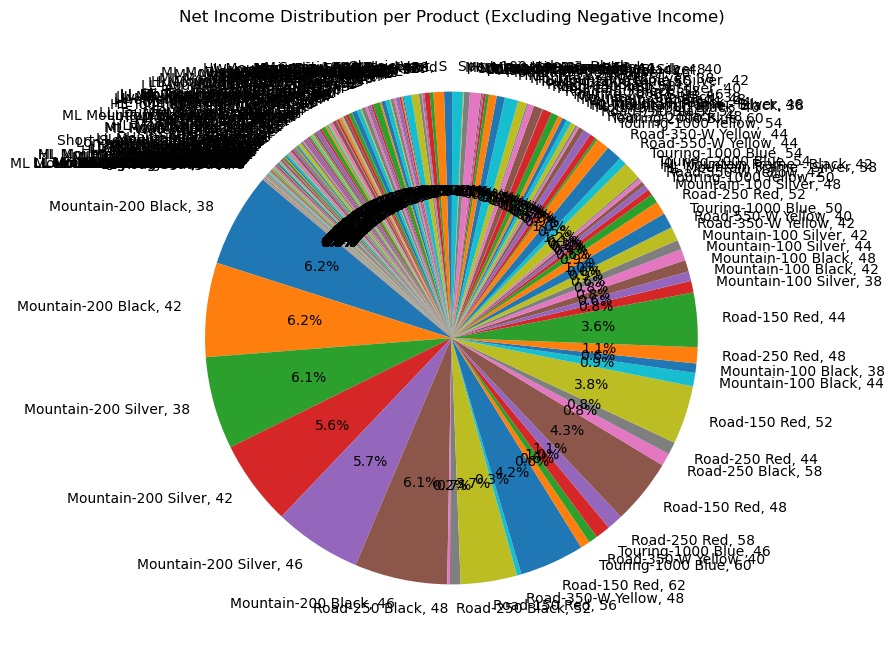

In [41]:

# Filter out rows where NetIncome is negative
positive_net_income_df = df[df['NetIncome'] > 0]

# Now, use this filtered DataFrame for plotting
net_income = positive_net_income_df['NetIncome']
labels = positive_net_income_df['ProductName']

# Create a pie chart
plt.figure(figsize=(10, 8))  # Set the figure size
plt.pie(net_income, labels=labels, autopct='%1.1f%%', startangle=140)  # autopct displays the percentage value

# Add a title
plt.title('Net Income Distribution per Product (Excluding Negative Income)')

# Show the plot
plt.show()

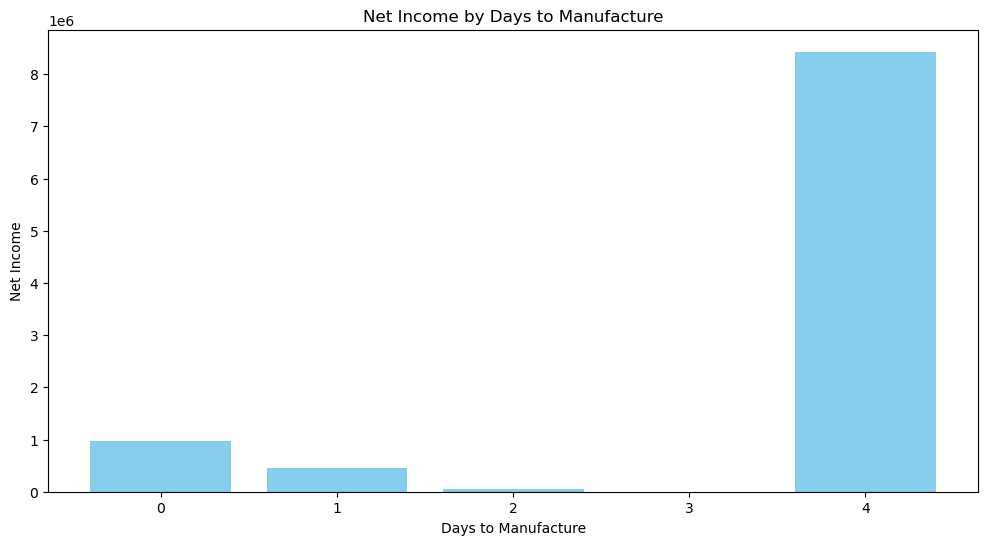

In [42]:

# Grouping the data by 'DaysToManufacture' and summing up the 'NetIncome'
grouped_data = df.groupby('DaysToManufacture')['NetIncome'].sum().reset_index()

# Sorting the data for better visualization (optional)
grouped_data = grouped_data.sort_values(by='DaysToManufacture')

# Creating the bar chart
plt.figure(figsize=(12, 6))
plt.bar(grouped_data['DaysToManufacture'], grouped_data['NetIncome'], color='skyblue')

# Adding title and labels
plt.title('Net Income by Days to Manufacture')
plt.xlabel('Days to Manufacture')
plt.ylabel('Net Income')

# Displaying the chart
plt.show()